# Bayesian Network with PyMC

This notebook demonstrates the construction of a Bayesian Network using PyMC to perform inference on the diagnosis of Autism Spectrum Disorder (ASD).

The inference is based on both subject metadata—such as **age** and **sex**—and **graph-based metrics** computed from brain regions of interest (ROIs) known to be associated with ASD. These metrics include:
- **Closeness centrality**
- **Clustering coefficient**
- **Degree centrality**

The dataset includes approximately **1,000 subjects**, balanced by sex and grouped into four age categories:
- Under 11 years
- 12–17 years
- 18–25 years
- Over 25 years

We define a probabilistic model that incorporates these variables, then use sampling to infer posterior distributions. The results are analysed and visualised to better understand the probabilistic relationships influencing ASD diagnosis.

## Data Preprocessing

In [5]:
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import DiscreteBayesianNetwork
import numpy as np
import os
import pandas as pd

# Constants
REGIONS_ORDER = [
    'Prefrontal Cortex', 'Insula', 'Cingulate Cortex',
    'Hippocampus', 'Amygdala', 'Temporal Region', 'Cerebellum'
]
AGE_GROUPS = ['11-', '12_17', '18_25', '25+']
METRIC_TYPES = ['Closeness', 'Clustering', 'Degree']

# Load, filter, and normalize subject data
def process_data(root_dir='analysis/abide'):
    subjects_data = []
    normalization_params = {ag: {mt: {'min': np.inf, 'max': -np.inf} for mt in METRIC_TYPES} for ag in AGE_GROUPS}
    seen_subjects = set()

    for root, dirs, files in os.walk(root_dir):
        if 'abide_roi_metrics.csv' in files:
            path_parts = root.split(os.sep)
            age_group = next((ag for ag in AGE_GROUPS if ag in path_parts), None)
            label = 0 if 'control' in path_parts else 1

            if not age_group:
                continue

            df = pd.read_csv(os.path.join(root, 'abide_roi_metrics.csv'))

            for subject_id, group in df.groupby('SubjectID'):
                if subject_id in seen_subjects:
                    continue
                seen_subjects.add(subject_id)

                # Ensure all expected ROIs are present
                if len(group) != len(REGIONS_ORDER):
                    continue

                # Sort regions in a fixed order
                group['Region'] = pd.Categorical(group['Region'], categories=REGIONS_ORDER, ordered=True)
                sorted_group = group.sort_values('Region')

                metrics = []
                for _, row in sorted_group.iterrows():
                    for mt in METRIC_TYPES:
                        val = row[mt]
                        metrics.append(val)

                        # Track min/max for normalization
                        if val < normalization_params[age_group][mt]['min']:
                            normalization_params[age_group][mt]['min'] = val
                        if val > normalization_params[age_group][mt]['max']:
                            normalization_params[age_group][mt]['max'] = val

                subjects_data.append({
                    'age_group': age_group,
                    'sex': 0 if sorted_group['Sex'].iloc[0] == 'M' else 1,
                    'age': sorted_group['Age'].iloc[0],
                    'metrics': metrics,
                    'label': label
                })

    # Normalize features and binarize metrics
    data_vectors = []
    for subj in subjects_data:
        ag = subj['age_group']
        normalized = []
        for i, mt in enumerate(METRIC_TYPES * len(REGIONS_ORDER)):
            mt_type = METRIC_TYPES[i % 3]
            val = subj['metrics'][i]
            min_val = normalization_params[ag][mt_type]['min']
            max_val = normalization_params[ag][mt_type]['max']
            norm_val = 0.5 if max_val == min_val else (val - min_val) / (max_val - min_val)
            normalized.append(norm_val)

        vector = {
            'Sex': subj['sex'],
            'AgeGroup': ag,
            'Age': subj['age'],
            'Metrics': normalized,
            'Diagnosis': subj['label']
        }
        data_vectors.append(vector)

    return data_vectors

# Convert normalized data into a DataFrame with binary features
def create_dataframe(processed_data):
    rows = []
    for entry in processed_data:
        row = {
            'Sex': entry['Sex'],
            'AgeGroup': entry['AgeGroup'],
        }

        metrics = entry['Metrics']
        cnt = 0
        for mt in METRIC_TYPES:
            for region in REGIONS_ORDER:
                col_name = f"{mt}_{region}"
                row[col_name] = 1 if metrics[cnt] > 0.5 else 0
                cnt += 1

        row['Diagnosis'] = entry['Diagnosis']
        rows.append(row)

    return pd.DataFrame(rows)

## Training of the Bayesian Network

In [6]:
# Build and train the Bayesian Network
def build_and_train_bn(df):
    edges = []
    metric_columns = []

    # Define BN structure: Sex & AgeGroup → metrics → Diagnosis
    for mt in METRIC_TYPES:
        for region in REGIONS_ORDER:
            col_name = f"{mt}_{region}"
            metric_columns.append(col_name)
            edges.append(('Sex', col_name))
            edges.append(('AgeGroup', col_name))
            edges.append((col_name, 'Diagnosis'))

    model = DiscreteBayesianNetwork(edges)

    df['AgeGroup'] = df['AgeGroup'].astype('category')
    df['Sex'] = df['Sex'].astype(int)
    df['Diagnosis'] = df['Diagnosis'].astype(int)

    # Learn CPDs using Maximum Likelihood Estimation
    model.fit(df, estimator=MaximumLikelihoodEstimator)
    return model

# Main execution
processed_data = process_data()
if not processed_data:
    print("No data processed. Check directory structure and CSV files.")
else:
    print(f"Number of subjects processed: {len(processed_data)}")
    df = create_dataframe(processed_data)
    print("Preview of processed data:")
    print(df.head())

    model = build_and_train_bn(df)
    print("\nLearned CPDs:")
    for cpd in model.get_cpds():
        print(cpd)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Sex': 'N', 'AgeGroup': 'C', 'Closeness_Prefrontal Cortex': 'N', 'Closeness_Insula': 'N', 'Closeness_Cingulate Cortex': 'N', 'Closeness_Hippocampus': 'N', 'Closeness_Amygdala': 'N', 'Closeness_Temporal Region': 'N', 'Closeness_Cerebellum': 'N', 'Clustering_Prefrontal Cortex': 'N', 'Clustering_Insula': 'N', 'Clustering_Cingulate Cortex': 'N', 'Clustering_Hippocampus': 'N', 'Clustering_Amygdala': 'N', 'Clustering_Temporal Region': 'N', 'Clustering_Cerebellum': 'N', 'Degree_Prefrontal Cortex': 'N', 'Degree_Insula': 'N', 'Degree_Cingulate Cortex': 'N', 'Degree_Hippocampus': 'N', 'Degree_Amygdala': 'N', 'Degree_Temporal Region': 'N', 'Degree_Cerebellum': 'N', 'Diagnosis': 'N'}


Number of subjects processed: 989
Preview of processed data:
   Sex AgeGroup  Closeness_Prefrontal Cortex  Closeness_Insula  \
0    0    12_17                            0                 0   
1    1    12_17                            0                 1   
2    0    12_17                            0                 1   
3    0    12_17                            0                 1   
4    0    12_17                            0                 1   

   Closeness_Cingulate Cortex  Closeness_Hippocampus  Closeness_Amygdala  \
0                           0                      0                   0   
1                           0                      0                   1   
2                           0                      0                   1   
3                           1                      0                   1   
4                           0                      0                   1   

   Closeness_Temporal Region  Closeness_Cerebellum  \
0                          0   

## Results Visualization

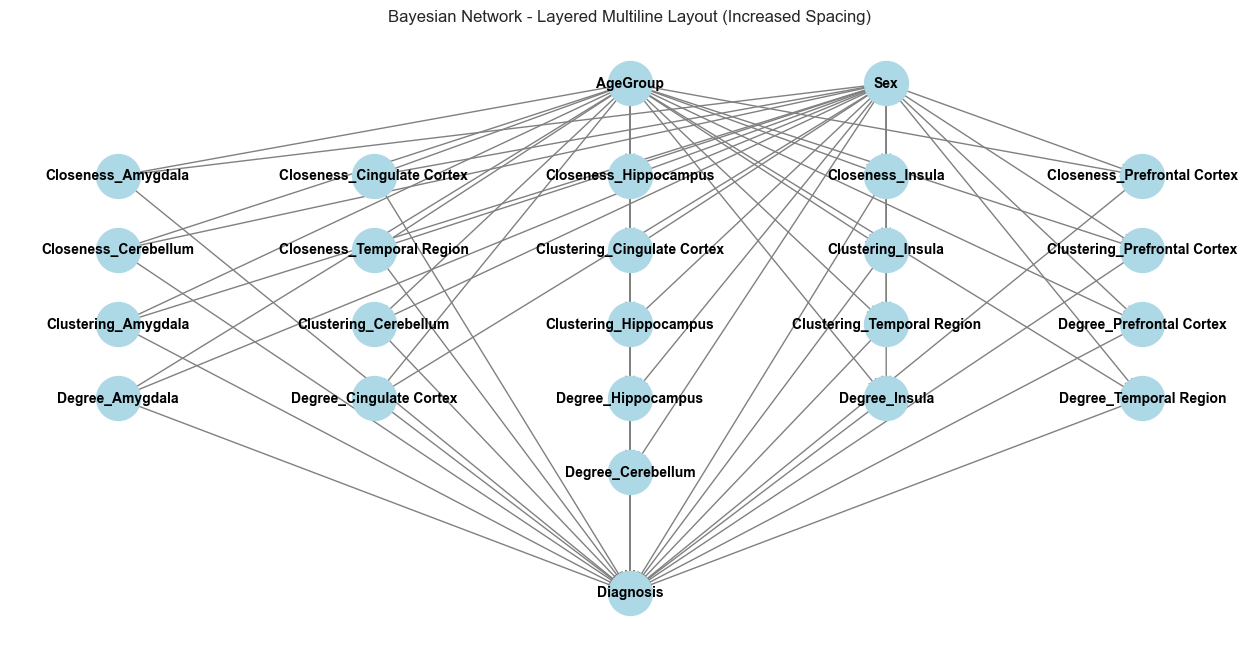

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Plot Bayesian Network using layered layout
def plot_bn_layered_multiline_sol1(model):
    G = nx.DiGraph()
    G.add_nodes_from(model.nodes())
    G.add_edges_from(model.edges())

    fixed_nodes_top = ["Sex", "AgeGroup"]
    fixed_nodes_bottom = ["Diagnosis"]
    metric_nodes = [n for n in G.nodes() if n not in fixed_nodes_top + fixed_nodes_bottom]

    pos = {}

    # Position top layer nodes
    y_top = 3
    spacing_top = 6.0
    for i, node in enumerate(sorted(fixed_nodes_top)):
        pos[node] = (i * spacing_top, y_top)

    # Position metric nodes in multiple horizontal lines
    chunk_size = 5
    chunks = [metric_nodes[i:i + chunk_size] for i in range(0, len(metric_nodes), chunk_size)]
    y_start = 2
    y_step = -0.8
    current_y = y_start
    for chunk in chunks:
        spacing = 6.0
        n_nodes = len(chunk)
        x_start = - ((n_nodes - 1) * spacing) / 2.0
        for i, node in enumerate(sorted(chunk)):
            pos[node] = (x_start + i * spacing, current_y)
        current_y += y_step

    # Position Diagnosis node at bottom
    pos["Diagnosis"] = (0, current_y - 0.5)

    # Center layout horizontally
    xs = [pt[0] for pt in pos.values()]
    if xs:
        x_mid = (min(xs) + max(xs)) / 2.0
        pos = {node: (x - x_mid, y) for node, (x, y) in pos.items()}

    # Plot the network
    plt.figure(figsize=(16, 8))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    plt.title("Bayesian Network - Layered Multiline Layout (Increased Spacing)")
    plt.axis('off')
    plt.show()


plot_bn_layered_multiline_sol1(model)